# Loading Packages & Initialization

be sure to set:
* nl.model
* model.type
* output_folder
* iteration_budget
* selected_ins

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(plotly) # For beautiful plotting
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
Is_Headless <- 1
nl.model <- "Segregation"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
folder.path <- "C:/Users/paslanpatir/Desktop/TEZ_v2/"
model.path <- paste0(folder.path, nl.model, ".nlogo")

if (Is_Headless == 0) {
    NLStart(nl.path, gui = TRUE, nl.jarname = "netlogo-6.0.4.jar")
    NLLoadModel(model.path)
} else {
    NLStart(nl.path, gui = FALSE, nl.jarname = "netlogo-6.0.4.jar", nl.obj = nl.model)
    NLLoadModel(model.path, nl.obj = nl.model)
}

In [5]:
model.type = ifelse(nl.model == "Segregation", "basic", "dummy")
# the path of data folder
data.path = paste0(folder.path,"data/")
# the path for outputs to be record
output.folder = paste0("outputs_coeff_deneme_",Sys.Date())
dir.create(file.path(folder.path, output.folder), showWarnings = FALSE)

outputs.path = paste0(folder.path,output.folder,"/")

In [6]:
# Read Me File to keep info about the output folder
ReadMe = paste0(outputs.path,"ReadMe_",model.type,".txt")

# Model Parameters & Functions

## Set model parameters

In [9]:
## Set model parameters
 # Number of replications for each instance
nofrep = 10 

 # order feature names according to their definition order in run_model
if (model.type == "basic") {
    feature_names = c("density", "%-similar-wanted")
} else if (model.type == "dummy") {
    feature_names = c("density", "%-similar-wanted", "budget-multiplier-dummy", "density-multiplier-dummy", 
        "noise-dummy", "tick-limit")
}
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 300
mtry = 2

## Set user parameters

In [10]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "coefvar" #, "range" 

# Number of iterations
iteration_budget = 11

# Number of instances
unlabeled_ins = 100 
test_ins = 100
train_ins_oneshot = 100
train_ins_Ad = 50

# Set selection parameters
selected_ins = 5 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step

seed.oneshot = 0
seed.Ad = 0

In [11]:
write(paste0( "model =",nl.model,"\n"
             ,"nofrep =",nofrep,"\n"
             ,"ntree =",ntree,"\n"
             ,"mtry =",mtry,"\n"
             ,"iteration_budget =",iteration_budget,"\n"
             ,"unlabeled_ins =",unlabeled_ins,"\n"
             ,"test_ins =",test_ins,"\n"
             ,"train_ins_Ad =",train_ins_Ad,"\n"
             ,"selected_ins =",selected_ins,"\n"
             ,"h =",h,"\n"
             ,paste0(c("seed.oneshot =",seed.oneshot),collapse = " "),"\n"
             ,paste0(c("seed.Ad =",seed.Ad),collapse = " "),"\n"
             ,"Date =", Sys.Date()
             )
      ,ReadMe, append=TRUE, sep = "\n" )    

## Define functions

### run_model

In [12]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format   
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]), nl.obj = nl.model)      
    }
    NLCommand("setup", nl.obj = nl.model)
    NLDoCommand(100, "go", nl.obj = nl.model) 
    result <- NLReport(output_name, nl.obj = nl.model)
    return(result)   
}

### run_replicas

In [13]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

### run_ABM

In [14]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


### error functions

In [15]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


### get_test_predictions

In [16]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:3), nrow = 1, ncol = 3)
     performance_temp[1] =  mae(output_variables_1 , output_variables_2)
     performance_temp[2] = rmse(output_variables_1 , output_variables_2)
     performance_temp[3] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

### sample_selection

In [17]:
# Adaptive sample selection function with an uncertainty measure depending on 'selection_metric'
sample_selection <- function(selected_ins, unlabeled_set, model) {
    ind_pred <- t(predict(model, unlabeled_set, predict.all = TRUE)$individual) %>% 
        data.table()  # predictions by each tree in the forest
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev, ".", "sd")
    ind_pred_eval = cbind(ind_pred_eval, s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[, .(range = abs(range[, 1] - range[, 2]))]
    setnames(range, "range.V1", "range")
    ind_pred_eval = cbind(ind_pred_eval, range)
    
    #coeff variance calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev, ".", "sd")
    s_mean = sapply(ind_pred, mean) %>% data.table()
    setnames(s_mean, ".", "mean")
    coeff_var = cbind(s_dev,s_mean) 
    coeff_var = coeff_var[,.(c_var = (sd / mean)* 100)]
    ind_pred_eval = cbind(ind_pred_eval, coeff_var)
    
    ind_pred_eval[, `:=`(idx, 1:.N)]
    
    if (selection_metric == "sd") {
        ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    } else if (selection_metric == "range") {
        ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    } else if (selection_metric == "coefvar") {
        ind_pred_eval = ind_pred_eval[order(-coeff_var)][1:selected_ins]
    }
    
    unlabeled_set[, `:=`(idx, 1:.N)]
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}

### random_sample_selection

In [18]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

### get_variable_importance

In [19]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

### feature_elimination

In [20]:
feature_elimination <- function(h,total_numof_eliminated_vars,ranked_features){ 
    numof_columns_left = length(ranked_features) - (total_numof_eliminated_vars + h)
    columns_left = ranked_features[1:numof_columns_left]
    
    eliminated_columns = setdiff((length(ranked_features) - total_numof_eliminated_vars), numof_columns_left)
    eliminated_columns = ranked_features[eliminated_columns]
    
    # update total_numof_eliminated_vars
    total_numof_eliminated_vars = length(ranked_features) - length(columns_left)
    
    return(list(columns_left,total_numof_eliminated_vars,h,eliminated_columns))
 }

# Unlabeled Data Pool

## Latin hyper cube sampling

In [21]:
unlabeled_pool.name= paste0(data.path,"unlabeled_pool","_",model.type,"_",unlabeled_ins,".csv")
unlabeled_pool <- fread(unlabeled_pool.name)  

data_candidates = copy(unlabeled_pool)

Saving 6.67 x 6.67 in image


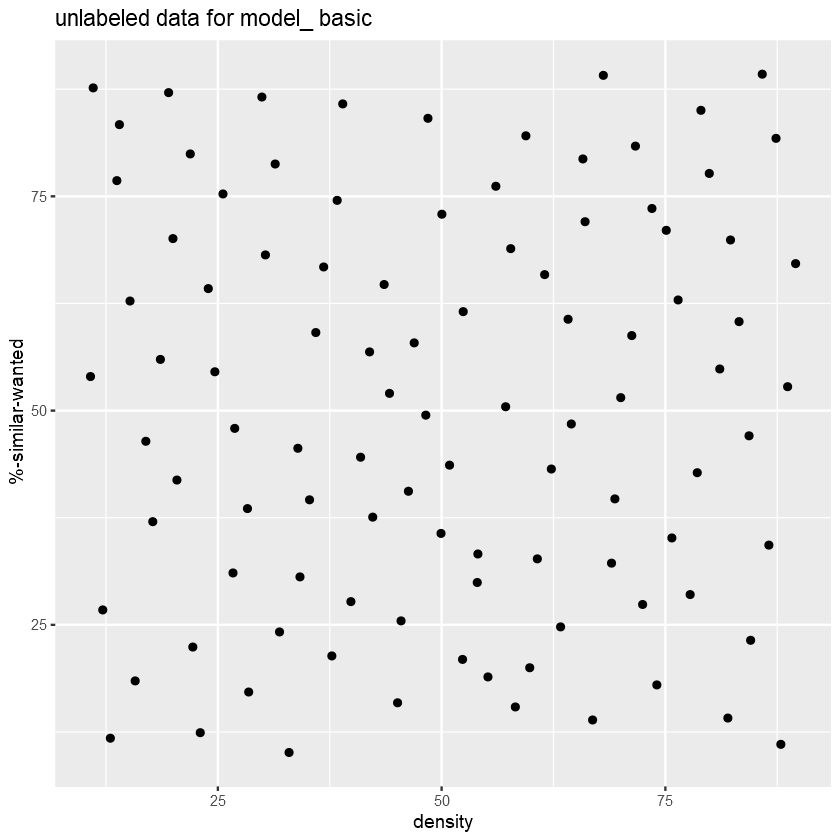

In [22]:
data_candidates_plot = ggplot(data = data_candidates[,.(density,`%-similar-wanted`)], aes(x = density, y = `%-similar-wanted`)) +
                    geom_point() +
                    ggtitle(paste0("unlabeled data for model_ ", model.type))
data_candidates_plot
ggsave(paste0(outputs.path,"unlabeled_", model.type,".png"))

#pca_unlabeled_pool <- princomp(data_candidates[,-c("idx")], cor = TRUE, scores = TRUE)
#pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
#p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("unlabeled data for model_ ", model.type))
#p_unlabeled_pool
#ggsave(paste0(outputs.path,"unlabeled_", model.type,".png"))

# Test Set

In [23]:
test_set.name= paste0(data.path,"test_set","_",model.type,"_",test_ins,".csv")
test_set <- fread(test_set.name)  

In [ ]:
test_set_plot = ggplot(data = test_set[,.(density,`%-similar-wanted`)], aes(x = density, y = `%-similar-wanted`)) +
                    geom_point() +
                    ggtitle(paste0("test data for model_ ", model.type))
test_set_plot
ggsave(paste0(outputs.path,"test_set_", model.type,".png"))

#pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
#pca_test_set_components <- get_pca_ind(pca_test_set)
#p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#p_test_set
#ggsave(paste0(outputs.path,"test_set_", model.type,".png"))

# Benchmark : One-shot sampling, No feature elimination

## One-Shot Training Set

In [ ]:
training_set.name= paste0(data.path,"training_set","_",model.type,"_",train_ins_oneshot,"_seed",seed.oneshot,".csv")
training_set <- fread(training_set.name) 

In [ ]:
one_shot_data = copy(training_set)

### Visualization

In [ ]:
one_shot_plot = ggplot(data = one_shot_data[,.(density,`%-similar-wanted`,output)], aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(colour = output)) +
                    labs(legend = "output") +
                    ggtitle(paste0("one_shot_data for model_ ", model.type))
one_shot_plot
ggsave(paste0(outputs.path,"one_shot_data_", model.type,".png"))

#pca_training_set <- princomp(one_shot_data[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)
#
#pca_training_set_components <- get_pca_ind(pca_training_set)
#pca_training_set_components <-cbind(pca_training_set_components$coord[,1:2],training_set[,.SD, .SDcols = c("output")])
#p_training_set <- ggplot(data = pca_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             labs(legend = "output") +
#             ggtitle(paste0("one_shot_data for model_ ", model.type)) 
#
#p_training_set
#ggsave(paste0(outputs.path,"one_shot_data_", model.type,".png"))

## Train & Test Metamodel

In [ ]:
model_oneshot <- randomForest(x = one_shot_data[, -c("output")], y = one_shot_data$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot

In [ ]:
# save the model for the sake of reproducibility
model_Sub.path = paste0(outputs.path,"model_oneshot.rds")
saveRDS(model_oneshot, model_Sub.path)

In [ ]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
plot(model_oneshot$mse, type="l")

In [ ]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())
# Keep test set error records
performance_table_oneshot = rbind(performance_table_oneshot, data.table(1, test_prediction_oneshot[[2]]), use.names = FALSE)

output_variables = test_prediction_oneshot[[3]]    


In [ ]:
fwrite(performance_table_oneshot,paste0(outputs.path,model.type,"_","performance_table_oneshot",".csv") )
fwrite(predictedLabels_oneshot,paste0(outputs.path,model.type,"_","predictedLabels_oneshot",".csv") )
fwrite(data.table("obb_error_oneshot",obb_error_oneshot),paste0(outputs.path,model.type,"_","obb_error_oneshot",".csv") )

In [ ]:
performance_table_oneshot
obb_error_oneshot
head(predictedLabels_oneshot)

In [ ]:
performance_molten_oneshot <- melt(data = performance_table_oneshot, id.vars = 'iter')
setnames(performance_molten_oneshot, c("variable","value"),c("errortype","errorvalue"))

In [ ]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values") +
            ggtitle(paste0("one_shot_predictions for model_ ", model.type)) 

p_oneshot
ggsave(paste0(outputs.path,"one_shot_predictions_", model.type,".png"))


# Random Sampling & No Feature Elimination

## Training Set

In [24]:
training_set.name = paste0(data.path, "training_set", "_", model.type, "_", train_ins_Ad, "_seed", seed.Ad, ".csv")
training_set_Ad <- fread(training_set.name)

In [25]:
adaptive_initial_data = copy(training_set_Ad)

## Visualization

In [ ]:
adaptive_initial_plot = ggplot(data = adaptive_initial_data[,.(density,`%-similar-wanted`,output)], aes(x = density, y = `%-similar-wanted`)) +
                           geom_point(aes(colour = output)) +
                           labs(legend = "output") +
                           ggtitle(paste0("initial_adaptive_data for model_ ", model.type))
adaptive_initial_plot
ggsave(paste0(outputs.path,"adaptive_initial_data_", model.type,".png"))

#pca_training_set_Ad <- princomp(adaptive_initial_data[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)
#
#pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
#pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],adaptive_initial_data[,.SD, .SDcols = c("output")])
#p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             labs(legend = "output") +
#             ggtitle(paste0("initial_adaptive_data for model_ ", model.type)) 
#
#p_training_set_Ad
#ggsave(paste0(outputs.path,"adaptive_initial_data_", model.type,".png"))

## Train & Test Metamodel

In [ ]:
## initialize record tables 
# Record train candidates
train_candidates_table = data.table()
# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())
## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [ ]:
set.seed(10)
print(paste0("Random sampling section start time : ",Sys.time()))
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Rd_",iter),model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_Rd_",iter),".rds")
    saveRDS(model_Sub, model_Sub.path)
                     
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)
    
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)    

    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
        
    ## sample selection from unlabeled data select candidates
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
        
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # run ABM to find outputs of train candidates
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))

    # Add new data to train data
    training_set_Ad = rbind(training_set_Ad,train_candidates[,-c("idx")])
    }
    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!
print(paste0("Random sampling section end time : ",Sys.time()))

In [ ]:
#iter = 1
#while(iter <= iteration_budget){  
#    model_Sub = get(paste0("model_Rd_",iter))
#    model_Sub.path = paste0(outputs.path,paste0("model_Rd_",iter),".rds")
#    
#    saveRDS(model_Sub, model_Sub.path)
#    
#     iter = iter + 1
#}
#

In [ ]:
# Final records
FinalTrainData_Rd = copy(training_set_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [ ]:
fwrite(FinalTrainData_Rd,paste0(outputs.path,model.type,"_","FinalTrainData_Rd",".csv") )
fwrite(performance_table_Rd,paste0(outputs.path,model.type,"_","performance_table_Rd",".csv") )
fwrite(train_candidates_table_Rd,paste0(outputs.path,model.type,"_","train_candidates_table_Rd",".csv") )
fwrite(predictedLabels_table_Rd,paste0(outputs.path,model.type,"_","predictedLabels_table_Rd",".csv") )
fwrite(obb_error_Rd,paste0(outputs.path,model.type,"_","obb_error_Rd",".csv") )

In [ ]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

In [ ]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)+
          geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
          ggtitle(paste0("performances with Random Sampling for model_ ", model.type))
p_Rd
ggsave(paste0(outputs.path,"performance_table_Rd_", model.type,".png"))


## Final Visualization

In [ ]:
final_Rd_plot = ggplot(data = FinalTrainData_Rd, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with Random Sampling for model_ ", model.type))
final_Rd_plot
ggsave(paste0(outputs.path,"FinalTrainData_Rd_", model.type,".png"))

#pca_final_Rd_training_set <- princomp(FinalTrainData_Rd[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)
#
#pca_final_Rd_training_set_components <- get_pca_ind(pca_final_Rd_training_set)
#pca_final_Rd_training_set_components <-cbind(pca_final_Rd_training_set_components$coord[,1:2],FinalTrainData_Rd[,.SD, .SDcols = c("output")])
#p_final_Rd_training_set <- ggplot(data = pca_final_Rd_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with Random Sampling for model_ ", model.type))
#p_final_Rd_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_Rd_", model.type,".png"))

In [ ]:
png(paste0(outputs.path,"TrainData_Rd_Before_After_", model.type,".png"))
grid.arrange(adaptive_initial_plot,final_Rd_plot, ncol=2)
dev.off()
grid.arrange(adaptive_initial_plot,final_Rd_plot, ncol=2)
#ggsave(paste0(outputs.path,"TrainData_Rd_Before_After_", model.type,".png"))

# Adaptive Sampling & No Feature Elimination

## Training Set

In [26]:
training_set_Ad = copy(adaptive_initial_data)
unlabeled_pool =copy(data_candidates)

## Train & Test Metamodel

In [27]:
## initialize record tables Record train candidates
train_candidates_table = data.table()
# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())
## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [ ]:
set.seed(10)
print(paste0("Adaptive Sampling section start time : ",Sys.time()))

importance_table_Ad = data.table()

iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Ad_",iter),model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_Ad_",iter),".rds")
    saveRDS(model_Sub, model_Sub.path)
                    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.    
    ## sample selection from unlabeled data select candidates
        unlabeled_set <- copy(unlabeled_pool)
        train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
        
        # eliminate candidates from the unlabeled pool
        unlabeled_pool = unlabeled_pool[-train_candidates$idx]
        rm(unlabeled_set)
        
        # run ABM to find outputs of train candidates
        print(paste0("ABM train_candidate run start time : ",Sys.time()))
        train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
        print(paste0("ABM train_candidate run end time : ",Sys.time()))
        
        train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
        
        # add labeled candidates to the train data
        training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
    }
    
    importance_table_Ad = rbind(importance_table_Ad,data.table("iter_no" = iter, t(importance(get(paste0("model_Ad_",iter)), type = 1, scale = FALSE))))
    iter = iter + 1
}
print(paste0("Adaptive Sampling section end time : ",Sys.time()))

[1] "Adaptive Sampling section start time : 2020-01-25 17:12:01"


In [ ]:
# Final records
FinalTrainData_Ad = copy(training_set_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [ ]:
fwrite(importance_table_Ad,paste0(outputs.path,model.type,"_","importance_table_Ad",".csv") )
fwrite(FinalTrainData_Ad,paste0(outputs.path,model.type,"_","FinalTrainData_Ad",".csv") )
fwrite(performance_table_Ad,paste0(outputs.path,model.type,"_","performance_table_Ad",".csv") )
fwrite(train_candidates_table_Ad,paste0(outputs.path,model.type,"_","train_candidates_table_Ad",".csv") )
fwrite(predictedLabels_table_Ad,paste0(outputs.path,model.type,"_","predictedLabels_table_Ad",".csv") )
fwrite(obb_error_Ad,paste0(outputs.path,model.type,"_","obb_error_Ad",".csv") )

In [ ]:
head(importance_table_Ad)
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

In [ ]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)+
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            ggtitle(paste0("Performances with Adaptive Sampling for model_ ", model.type))
p_Ad
ggsave(paste0(outputs.path,"performance_table_Ad_", model.type,".png"))

## Final Visualization

In [ ]:
final_Ad_plot = ggplot(data = FinalTrainData_Ad, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with Adaptive Sampling for model_ ", model.type))
final_Ad_plot
ggsave(paste0(outputs.path,"FinalTrainData_Ad_", model.type,".png"))

#pca_final_Ad_training_set <- princomp(FinalTrainData_Ad[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)
#
#pca_final_Ad_training_set_components <- get_pca_ind(pca_final_Ad_training_set)
#pca_final_Ad_training_set_components <-cbind(pca_final_Ad_training_set_components$coord[,1:2],FinalTrainData_Ad[,.SD, .SDcols = c("output")])
#p_final_Ad_training_set <- ggplot(data = pca_final_Ad_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with Adaptive Sampling for model_ ", model.type)) 
#p_final_Ad_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_Ad_", model.type,".png"))

In [ ]:
png(paste0(outputs.path,"TrainData_Ad_Before_After_", model.type,".png"))
grid.arrange(adaptive_initial_plot,final_Ad_plot, ncol=2)
dev.off()
grid.arrange(adaptive_initial_plot,final_Ad_plot, ncol=2)
#ggsave(paste0(outputs.path,"TrainData_Ad_Before_After_", model.type,".png"))

# 3 Scenarios

In [ ]:
nrow(FinalTrainData_Ad)
nrow(one_shot_data)
nrow(FinalTrainData_Rd)

In [ ]:
oneshot_model = randomForest( x = one_shot_data[, -c("output")]
                             ,y = one_shot_data$output
                             , importance = TRUE,ntree = ntree, mtry = mtry)
random_model = randomForest( x = FinalTrainData_Rd[,.SD, .SDcols = feature_names]
                              ,y = FinalTrainData_Rd$output
                              ,importance = TRUE,ntree = ntree, mtry = mtry)
adaptive_model = randomForest( x = FinalTrainData_Ad[,.SD, .SDcols = feature_names]
                              ,y = FinalTrainData_Ad$output
                              ,importance = TRUE,ntree = ntree, mtry = mtry)

oneshot_model
random_model
adaptive_model

In [ ]:
pred_table = data.table()

pred_oneshot <- predict(oneshot_model, test_set)
pred_oneshot <- cbind(test_set,pred_oneshot)
pred_table = rbind(pred_table,pred_oneshot)

pred_rd <- predict(random_model, test_set)
pred_rd <- cbind(test_set,pred_rd)
pred_table = merge(pred_table,pred_rd
                      ,by = c(feature_names,"output")
                      ,all.x = T)

pred_ad <- predict(adaptive_model, test_set)
pred_ad <- cbind(test_set,pred_ad)
pred_table = merge(pred_table,pred_ad
                      ,by = c(feature_names,"output")
                      ,all.x = T)

pred_oneshot[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_oneshot)]
pred_rd[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_rd)]
pred_ad[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_ad)]                                                          
                        
rmse(pred_oneshot$output,pred_oneshot$pred_oneshot)
rmse(pred_rd$output,pred_rd$pred_rd)
rmse(pred_ad$output,pred_ad$pred_ad)

In [ ]:
fwrite(pred_table,paste0(outputs.path,model.type,"_","3scenario",".csv") )

In [ ]:
par(mfrow=c(3,1))
plot(oneshot_model$mse, type="l")
plot(random_model$mse, type="l")
plot(adaptive_model$mse, type="l")

# Random Sampling vs Uncertainty Sampling

## Final Data Comparison

In [ ]:
png(paste0(outputs.path,"TrainData_Rd&Ad_Before_After_", model.type,".png"))
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Rd_plot,final_Ad_plot,nrow=2, ncol=2)
dev.off()
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Rd_plot,final_Ad_plot,nrow=2, ncol=2)

#ggsave(paste0(outputs.path,"TrainData_Rd&Ad_Before_After_", model.type,".png"))

## Performance Comparison

In [ ]:
grid.arrange(p_Rd, p_Ad, ncol=2)

In [ ]:
performance_Rd_vs_Ad = rbind(performance_molten_Rd[,.(iter,errortype,errorvalue, type = "Rd")],performance_molten_Ad[,.(iter,errortype,errorvalue, type = "Ad")])
p_Rd_vs_Ad = ggplot(performance_Rd_vs_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap(~type) +
            ggtitle("performance_table_Rd&Ad")
p_Rd_vs_Ad
ggsave(paste0(outputs.path,"performance_table_Rd&Ad_", model.type,".png"))

In [ ]:
ggplotly(p_Rd_vs_Ad)

In [ ]:
comp = performance_Rd_vs_Ad[iter == 10 & errortype =="rmse"]
comp[, oneshot_error := performance_molten_oneshot[errortype =="rmse"]$errorvalue]      
comp[,diff := (errorvalue - oneshot_error) ]
comp[,diff_perc := (errorvalue - oneshot_error) / oneshot_error ]
comp

# Adaptive Sampling & Feature Elimination 

## Training Set

In [ ]:
training_set_Ad = copy(adaptive_initial_data)
unlabeled_pool =copy(data_candidates)

## Train and Test Metamodel

In [ ]:
# Decide on strategy:
if (model.type == "basic") {
    sample_selection_iteration_order = c(1:(iteration_budget - 1))
    feature_elimination_iteration_order = c(iteration_budget - 1)
} else if (model.type == "dummy") {
    sample_selection_iteration_order = c(1:(iteration_budget - 1))
    feature_elimination_iteration_order = c((iteration_budget - 4):(iteration_budget - 1))
}

In [ ]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

# Record iteration history
iteration_history = data.table(iter_no = numeric(), IsFeatureEliminated = logical(), IsDataSelected = logical())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

# specify variables(columns) to be used initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0

In [ ]:
set.seed(10)
print(paste0("AdFe section start time : ",Sys.time()))
iter = 1
while (iter <= iteration_budget) {
    
    trainx = training_set_Ad[, .SD, .SDcols = columns_left]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest(x = trainx, y = trainy, importance = TRUE, ntree = ntree, mtry = mtry)
    assign(paste0("model_AdFe_", iter), model_Sub)
    model_Sub.path = paste0(outputs.path,paste0("model_AdFe_",iter),".rds")
    saveRDS(model_Sub, model_Sub.path)
    
    
    if (length(columns_left) == length(feature_names)) {
        ranked_features = get_variable_importance(model_Sub)
    }
    # Keep training set error records
    obb_error = rbind(obb_error, data.table(iter, obb_error_func(model_Sub)), use.names = FALSE)
    
    # Test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub, test_set, error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
    
    # update iteration_history
    iteration_history = rbind(iteration_history, data.table(iter, 0, 0), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
          if (iter %in% sample_selection_iteration_order) {
              ## sample selection from unlabeled data select candidates
              unlabeled_set <- copy(unlabeled_pool)
              train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
              
              # eliminate candidates from the unlabeled pool
              unlabeled_pool = unlabeled_pool[-train_candidates$idx]
              rm(unlabeled_set)
              
              # run ABM to find outputs of train candidates
              print(paste0("ABM train_candidate run start time : ",Sys.time()))
              train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
              print(paste0("ABM train_candidate run end time : ",Sys.time()))
              
              train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
              
              # add labeled candidates to the train data
              training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
              
              # update iteration_history
               iteration_history[iter]$IsDataSelected= 1
          }
          if (iter %in% feature_elimination_iteration_order) {
              ## feature elimination apply feature elimination
              feature_elimination_result = feature_elimination(h, total_numof_eliminated_vars, ranked_features)
              
              columns_left = feature_elimination_result[[1]]  # 
              eliminated_columns = feature_elimination_result[[4]]  #   not necessary
              total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])
              numof_eliminated_vars = as.numeric(feature_elimination_result[3])  #   not necessary 
              
              # update iteration_history
              iteration_history[iter]$IsFeatureEliminated= 1
          }
    }
iter = iter + 1  
}
print(paste0("AdFe section end time : ",Sys.time()))

In [ ]:
iter = 1
importance_table_AdFe = data.table()

while(iter <= (iteration_budget - 4) ){ 
    importance_table_AdFe = rbind(importance_table_AdFe,data.table("iter_no" = iter, t(importance(get(paste0("model_AdFe_",iter)), type = 1, scale = FALSE))))
iter = iter + 1    
}

In [ ]:
# Final records
FinalTrainData_AdFe = copy(training_set_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [ ]:
fwrite(importance_table_AdFe,paste0(outputs.path,model.type,"_","importance_table_AdFe",".csv") )
fwrite(FinalTrainData_AdFe,paste0(outputs.path,model.type,"_","FinalTrainData_AdFe",".csv") )
fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
fwrite(train_candidates_table_AdFe,paste0(outputs.path,model.type,"_","train_candidates_table_AdFe",".csv") )
fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )
fwrite(obb_error_AdFe,paste0(outputs.path,model.type,"_","obb_error_AdFe",".csv") )
fwrite(iteration_history,paste0(outputs.path,model.type,"_","iteration_history",".csv") )

In [ ]:
iteration_history

In [ ]:
performance_molten_AdFe <- melt(data = performance_table_AdFe
                             , id.vars = 'iter')
setnames(performance_molten_AdFe, c("variable","value"),c("errortype","errorvalue"))
p_AdFe = ggplot(performance_molten_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
          #  geom_vline(xintercept = iteration_history[IsDataSelected==1]$iter_no + 1, linetype = "dotdash",color = "yellow") +
            ggtitle(paste0("Performances with AdFe for model_ ", model.type))
p_AdFe
ggsave(paste0(outputs.path,"performance_table_AdFe_", model.type,".png"))

## Final Visualization

In [ ]:
final_AdFe_plot = ggplot(data = FinalTrainData_AdFe, aes(x = density, y = `%-similar-wanted`)) +
                     geom_point(aes(colour = output)) +
                     labs(legend = "output") +
                     ggtitle(paste0("Final Data with AdFe for model_ ", model.type))
final_AdFe_plot
ggsave(paste0(outputs.path,"FinalTrainData_AdFe_", model.type,".png"))

#pca_final_AdFe_training_set <- princomp(FinalTrainData_AdFe[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)
#
#pca_final_AdFe_training_set_components <- get_pca_ind(pca_final_AdFe_training_set)
#pca_final_AdFe_training_set_components <-cbind(pca_final_AdFe_training_set_components$coord[,1:2],FinalTrainData_AdFe[,.SD, .SDcols = c("output")])
#p_final_AdFe_training_set <- ggplot(data = pca_final_AdFe_training_set_components, aes(x = Dim.1, y = Dim.2)) +
#             geom_point(aes(colour = output)) +
#             labs(legend = "output") +
#             ggtitle(paste0("Final Data with AdFe for model_ ", model.type)) 
#p_final_AdFe_training_set
#ggsave(paste0(outputs.path,"FinalTrainData_AdFe_", model.type,".png"))

# Adaptive Sampling with/without Feature Elimination

In [ ]:
png(paste0(outputs.path,"TrainData_Ad&AdFe_Before_After_", model.type,".png"))
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Ad_plot,final_AdFe_plot,nrow=2, ncol=2)
dev.off()
grid.arrange(one_shot_plot, adaptive_initial_plot,final_Ad_plot,final_AdFe_plot,nrow=2, ncol=2)

In [ ]:
performance_Ad_vs_AdFe = rbind(performance_molten_Ad[,.(iter,errortype,errorvalue, type = "Ad")], performance_molten_AdFe[,.(iter,errortype,errorvalue, type = "AdFe")])
p_Ad_vs_AdFe = ggplot(performance_Ad_vs_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap(~type) +
            ggtitle(paste0("Performances with Ad and AdFe for model_ ", model.type))
p_Ad_vs_AdFe
ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

In [ ]:
ggplotly(p_Ad_vs_AdFe)

In [ ]:
performance_Rd_vs_Ad_vs_AdFe = rbind(performance_Rd_vs_Ad,performance_molten_AdFe[,.(iter,errortype,errorvalue, type = "AdFe")])


p_Rd_vs_Ad_vs_AdFe = ggplot(performance_Rd_vs_Ad_vs_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap( ~type  ) +
            ggtitle("performance_table_Rd&Ad&AdFe")
p_Rd_vs_Ad_vs_AdFe
ggsave(paste0(outputs.path,"performance_table_Rd&Ad&Fe_", model.type,".png"))

# Alternative Test Sets

## Different Seeds

In [ ]:
#test.seed.5.2 = "old"
#test_ins_5.2 = 400
#
#test_set.name.5.2= paste0(data.path,"test_set","_",model.type,"_",test_ins_5.2,"_seed",test.seed.5.2,".csv")
#test_set.5.2 <- fread(test_set.name.2)  
#
#pca_test_set.5.2 <- princomp(test_set.5.2, cor = TRUE, scores = TRUE)
#pca_test_set_components.5.2 <- get_pca_ind(pca_test_set.5.2)
#p_test_set.5.2 <- ggplot(data = data.table(pca_test_set_components.5.2$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#p_test_set.5.2

In [ ]:
## Record model performances
#performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#
### initialize variables
## keep test set undistorted
#predictedLabels_table = copy(test_set.5.2)
#
#iter = 1
#while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_", iter)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set.5.2, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
#iter = iter + 1  
#}
#
#performance_table_AdFe.5.2 = copy(performance_table)
#predictedLabels_table_AdFe.5.2 = copy(predictedLabels_table)
#    
#
##fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
##fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )

In [ ]:
#performance_molten_AdFe.5.2 <- melt(data = performance_table_AdFe.5.2
#                             , id.vars = 'iter')
#setnames(performance_molten_AdFe.5.2, c("variable","value"),c("errortype","errorvalue"))

In [ ]:
#performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5_vs_AdFe.5.2 = rbind( performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5
#                                                           ,performance_molten_AdFe.5.2[,.(iter,errortype,errorvalue, type = "AdFe.5.2")])
#
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5_vs_AdFe.5.2 = ggplot(performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5_vs_AdFe.5.2, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_wrap(~type) +
#            ggtitle(paste0("Performances with Ad,AdFe,AdFe.3,AdFe.4,AdFe.5,AdFe.5.2 for model_ ", model.type))
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5_vs_AdFe.5.2
##ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

## Different Size

### test_ins = 200

In [ ]:
#test_ins_3 = 200
#test_set.name.3= paste0(data.path,"test_set","_",model.type,"_",test_ins_3,".csv")
#test_set.3 <- fread(test_set.name.3)  
#

In [ ]:
## Record model performances
#performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())
#
### initialize variables
## keep test set undistorted
#predictedLabels_table = copy(test_set.3)
#
#test_prediction_oneshot = get_test_predictions(model_oneshot,test_set.3,error_type)
#performance_table_oneshot = rbind(performance_table_oneshot, data.table(1, test_prediction_oneshot[[2]]), use.names = FALSE)
#
#iter = 1
#while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_", iter)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set.3, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
#iter = iter + 1  
#}
#
#performance_table_oneshot.3 = copy(performance_table_oneshot)
#
#performance_table_AdFe.3 = copy(performance_table)
#predictedLabels_table_AdFe.3 = copy(predictedLabels_table)
#    
#
##fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
##fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )

In [ ]:
#performance_molten_oneshot.3 <- melt(data = performance_table_oneshot.3, id.vars = 'iter')
#setnames(performance_molten_oneshot.3, c("variable","value"),c("errortype","errorvalue"))
#
#performance_molten_AdFe.3 <- melt(data = performance_table_AdFe.3 , id.vars = 'iter')
#setnames(performance_molten_AdFe.3, c("variable","value"),c("errortype","errorvalue"))

In [ ]:
#GRID ARRANGE YAPMALI
#performance_Ad_vs_AdFe_vs_AdFe3 = rbind(performance_Ad_vs_AdFe, performance_molten_AdFe.3[,.(iter,errortype,errorvalue, type = "AdFe.3")])
#
#p_Ad_vs_AdFe_vs_AdFe3 = ggplot(performance_Ad_vs_AdFe_vs_AdFe3, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_wrap(~type) +
#            ggtitle(paste0("Performances with Ad,AdFe,AdFe.3 for model_ ", model.type))
#p_Ad_vs_AdFe_vs_AdFe3
##ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

### test_ins = 300

In [ ]:
#test_ins_4 = 300
#test_set.name.4= paste0(data.path,"test_set","_",model.type,"_",test_ins_4,".csv")
#test_set.4 <- fread(test_set.name.4)  
#
#pca_test_set.4 <- princomp(test_set.4, cor = TRUE, scores = TRUE)
#pca_test_set_components.4 <- get_pca_ind(pca_test_set.4)
#p_test_set.4 <- ggplot(data = data.table(pca_test_set_components.4$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#p_test_set.4

In [ ]:
## Record model performances
#performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#
### initialize variables
## keep test set undistorted
#predictedLabels_table = copy(test_set.4)
#
#iter = 1
#while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_", iter)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set.4, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
#iter = iter + 1  
#}
#
#performance_table_AdFe.4 = copy(performance_table)
#predictedLabels_table_AdFe.4 = copy(predictedLabels_table)
#    
#
##fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
##fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )

In [ ]:
#performance_molten_AdFe.4 <- melt(data = performance_table_AdFe.4
#                             , id.vars = 'iter')
#setnames(performance_molten_AdFe.4, c("variable","value"),c("errortype","errorvalue"))

In [ ]:
#performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4 = rbind(performance_Ad_vs_AdFe_vs_AdFe3, performance_molten_AdFe.4[,.(iter,errortype,errorvalue, type = "AdFe.4")])
#
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4 = ggplot(performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_wrap(~type) +
#            ggtitle(paste0("Performances with Ad,AdFe,AdFe.3,AdFe.4 for model_ ", model.type))
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4
##ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

### test_ins = 400

In [ ]:
#test_ins_5 = 400
#test_set.name.5= paste0(data.path,"test_set","_",model.type,"_",test_ins_5,".csv")
#test_set.5 <- fread(test_set.name.5)  
#
#pca_test_set.5 <- princomp(test_set.5, cor = TRUE, scores = TRUE)
#pca_test_set_components.5 <- get_pca_ind(pca_test_set.5)
#p_test_set.5 <- ggplot(data = data.table(pca_test_set_components.5$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
#                    geom_point() +
#                    ggtitle(paste0("test data for model_ ", model.type)) 
#p_test_set.5

In [ ]:
## Record model performances
#performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())
#
### initialize variables
## keep test set undistorted
#predictedLabels_table = copy(test_set.5)
#
#iter = 1
#while (iter <= iteration_budget) {
#    
#    model_Sub = copy(get(paste0("model_AdFe_", iter)))
#    
#     # Test the model on test set
#    test_predictions_Sub = get_test_predictions(model_Sub, test_set.5, error_type)
#    predictedLabels_Sub = test_predictions_Sub[[1]]
#    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
#    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
#    
#    # Keep test set error records
#    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
#iter = iter + 1  
#}
#
#performance_table_AdFe.5 = copy(performance_table)
#predictedLabels_table_AdFe.5 = copy(predictedLabels_table)
#    
#
##fwrite(performance_table_AdFe,paste0(outputs.path,model.type,"_","performance_table_AdFe",".csv") )
##fwrite(predictedLabels_table_AdFe,paste0(outputs.path,model.type,"_","predictedLabels_table_AdFe",".csv") )

In [ ]:
#performance_molten_AdFe.5 <- melt(data = performance_table_AdFe.5
#                             , id.vars = 'iter')
#setnames(performance_molten_AdFe.5, c("variable","value"),c("errortype","errorvalue"))

In [ ]:
#performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5 = rbind( performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4
#                                                           ,performance_molten_AdFe.5[,.(iter,errortype,errorvalue, type = "AdFe.5")])
#
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5 = ggplot(performance_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
#            geom_line(lwd=1) +
#            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
#            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
#            facet_wrap(~type) +
#            ggtitle(paste0("Performances with Ad,AdFe,AdFe.3,AdFe.4,AdFe.5 for model_ ", model.type))
#p_Ad_vs_AdFe_vs_AdFe3_vs_AdFe4_vs_AdFe.5
##ggsave(paste0(outputs.path,"performance_table_Ad&AdFe_", model.type,".png"))

In [ ]:
#head(train_candidates_table_AdFe)
#head(train_candidates_table_Ad)

In [ ]:
#varImpPlot(model_Ad)

# Quit NL

In [ ]:
NLQuit(nl.obj = nl.model)
#NLQuit(all=FALSE)